# Bitcoin prediction - Artificial Intelligence Exam Summer 2019
## Time series prediction using:
* Autoregressive Integrated Moving Average (ARIMA)
* Recurrent Neural Networks and Long-Short Term Memory

Bitcoin is the largest cryptocurrency in the world. It is a digital currency without need of a central bank or administrator. It is purely based off the peer-to-peer network. Since 2013 bitcoin price has been doubled by a 1000. The price is now around 9000 USD.

In this notebook we will investigate wether it is possible to predict future Bitcoin prices based on time series data.
The dataset is from [CryptoCompare](https://www.cryptocompare.com/).



In [1]:
import warnings
warnings.filterwarnings("ignore")
import itertools
import numpy as np
from math import sqrt
import statsmodels.api as sm
from datetime import datetime
import requests
import json

# Pandas - data analysis library.
import pandas as pd
from pandas import Series

# Sklearn - supervised and unsupervised learning algorithm library.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# Keras - neural-network library running on top of Tensorflow.
from keras.models import Sequential
from keras.layers import Dense
#from keras.layers import Flatten
from keras.layers import LSTM
#from keras.layers import CuDNNLSTM
#from keras.layers import RepeatVector
#from keras.layers import TimeDistributed
#from keras.layers import ConvLSTM2D
from keras.layers import Dropout

# Matplot library - interface for plotting.
import matplotlib.pyplot as plt
import matplotlib
from pylab import rcParams
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
plt.style.use('fivethirtyeight')

Using TensorFlow backend.


## Loading data from the Bitcoin API

In [2]:
# Get request to the API.
# The data is from today and 2000 days in the past. The price i calculated in USD.
request = requests.get('https://min-api.cryptocompare.com/data/histoday?fsym=BTC&tsym=USD&limit=2000')
# Loading the data from the API, which is in JSON format, into a DataFrame.
hist = pd.DataFrame(json.loads(request.content)['Data'])
# Setting the index of the dataframe to the coloum 'time'.
hist = hist.set_index('time')
# Converting the time coloum from UNIX timestamp to regular time format.
hist.index = pd.to_datetime(hist.index, unit='s')
# Creating a new coloum from the mean value of close, high, low and open.
hist['Weighted_Price'] = (hist.close + hist.high + hist.low + hist.open)/4
hist.tail()

,close,high,low,open,volumefrom,volumeto,Weighted_Price
time,,,,,,,
2019-05-24,7996.40,8165.45,7801.57,7876.50,51604.15,4.131627e+08,7959.9800
2019-05-25,8059.13,8140.82,7948.68,7996.40,22294.65,1.792063e+08,8036.2575
2019-05-26,8726.23,8779.00,7894.53,8059.13,57648.95,4.836637e+08,8364.7225
2019-05-27,8785.17,8931.53,8668.46,8726.23,57692.17,5.071647e+08,8777.8475
2019-05-28,8654.85,8818.71,8562.20,8785.17,26765.37,2.329951e+08,8705.2325


In [3]:
# Creating a new array containing the mean of each month
month_hist = hist['Weighted_Price'].resample('MS').mean()
month_hist.tail()
month_hist = month_hist['2016':]

In [4]:
# Checking if there is any zero values in our dataset.
print(f'NaN values: \n\n{hist.isna().sum()}')

NaN values: 

close             0
high              0
low               0
open              0
volumefrom        0
volumeto          0
Weighted_Price    0
dtype: int64


## Bitcoin graph

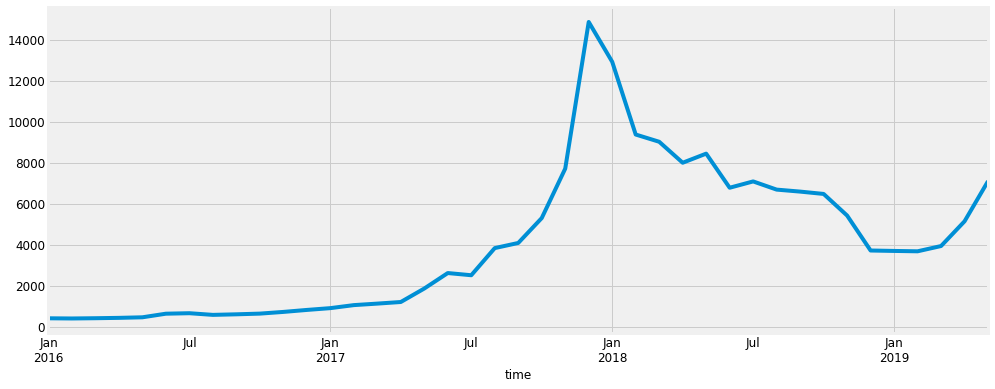

In [5]:
# Plotting the price over time i months.
month_hist.plot(figsize=(15,6))
plt.show()

---

# ARIMA prediction
ARIMA model is a statistical model for analyzing and forecasting time series data.

* Auto Regression tries to fit a line based on previous values. This is the 'p' in the ARIMA p-d-q formular. This value is setting how many months backwards we want to use to predict 1 month forward.

* Integrated making the data stationary. This is the 'd' in the ARIMA p-d-q formular. The data must be stationary in order to work with it in the SARIMA model. Stationary is, the mean variance should be constant.

* Moving Average is 



Skal vi skrive lidt tekst om hvad ARIMA er og hvad vi tager højde for i denne model?
Måske det om vi bruger seasonal?
Hvordan ser formlen ud?

desuden sagde hun der vigtigste var billede illustrationer. måske vi skal finde noget ift arima men også rnn lstm.
fx. til lstm kan vi tegne det som hun tegnede for os i dag når man forudsiger lstm

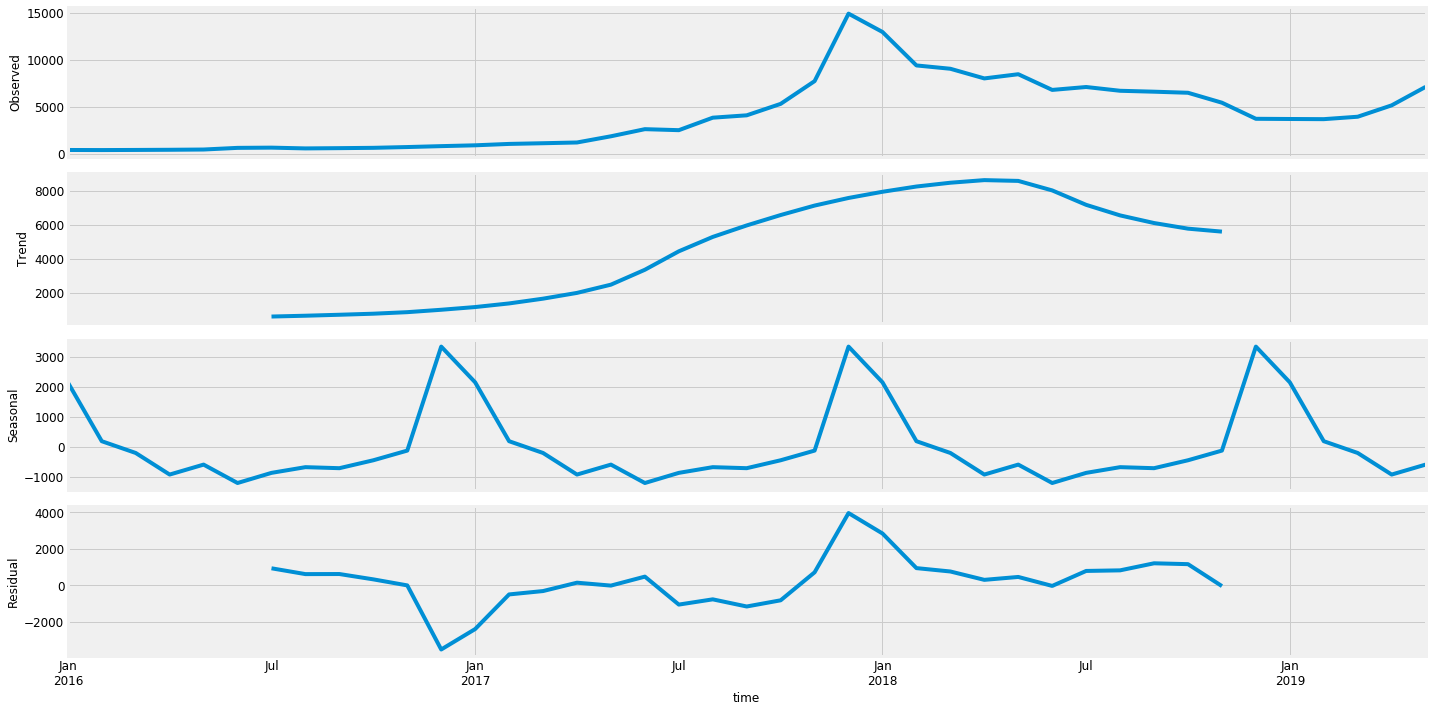

In [6]:
rcParams['figure.figsize'] = 20, 10

# Decomposing to visualize and identify trend, seasonality and residual.
# The graphs shows a opward going trend in the bitcoin market late 2016.
# There is a possible seasonality pattern at the end of the year with a big increase in price with a following decrease.
# Residual is noise. This is what there is left when removing trend and seasonal from the observed graph.
decomposition = sm.tsa.seasonal_decompose(month_hist, model='additive')
fig = decomposition.plot()
plt.show()

In [7]:
# ARIMA model (seasonal ARIMA, SARIMA)
# 'p' is the number of autoregressive terms (AR part). It allows to incorporate the effect of past values into our model. Intuitively, this would be similar to stating that it is likely to be warm tomorrow if it has been warm the past 3 days.
# 'd' is the number of nonseasonal differences needed for stationarity. Intuitively, this would be similar to stating that it is likely to be same temperature tomorrow if the difference in temperature in the last three days has been very small.
# 'q' is the number of lagged forecast errors in the prediction equation (MA part). This allows us to set the error of our model as a linear combination of the error values observed at previous time points in the past.
# These are the three integers (p, d, q) that are used to parametrize ARIMA models.
p = d = q = range(0, 3)

# pdq is an array of tuples. 
# Generating 2 arrays of tuples with examples of parameter combinations bewtween (0-1).
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 0, 2, 12)
SARIMAX: (0, 0, 2) x (0, 1, 0, 12)
SARIMAX: (0, 0, 2) x (0, 1, 1, 12)


In [8]:
# We are trying to find the combination with the lowest AIC(an estimator to realative quaility of statistical models for a given set of data).
for param in pdq:
    for param_seasonal in seasonal_pdq:
        # Try since not all combinations makes sense, some will throw an error.
        try:
            # Using Seasonal AutoRegressive Integrated Moving Average with eXogenous regressors model(SARIMAX).
            # eXogenous argument is not given, which makes it a SARIMA model.
            model = sm.tsa.statespace.SARIMAX(month_hist,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = model.fit()

            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        # If we come across an invalid combination, just skip it and continue.
        except:
            continue

ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:805.1857955744082
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:1133.82432298554
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:568.6390485240838


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(0, 2, 0, 12)12 - AIC:344.94262735910695
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:586.3326351571891
ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:1043.5317197378276
ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:346.00986132666884
ARIMA(0, 0, 0)x(1, 2, 0, 12)12 - AIC:85.52825593803782
ARIMA(0, 0, 0)x(2, 0, 0, 12)12 - AIC:338.40043587379273


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 0)x(2, 0, 1, 12)12 - AIC:340.6426939009415
ARIMA(0, 0, 0)x(2, 1, 0, 12)12 - AIC:79.57305170510917
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:743.0159106902116
ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:2392.809990642735
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:531.3516173781661
ARIMA(0, 0, 1)x(0, 2, 0, 12)12 - AIC:314.9040683657354
ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:558.4154064375527


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:2236.0103047161383
ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:325.842484644651
ARIMA(0, 0, 1)x(1, 2, 0, 12)12 - AIC:84.85849539775626
ARIMA(0, 0, 1)x(2, 0, 0, 12)12 - AIC:317.9583003486947
ARIMA(0, 0, 1)x(2, 0, 1, 12)12 - AIC:317.7724797554315


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 1)x(2, 1, 0, 12)12 - AIC:79.07938634981483
ARIMA(0, 0, 2)x(0, 0, 0, 12)12 - AIC:703.6814352436929
ARIMA(0, 0, 2)x(0, 0, 1, 12)12 - AIC:2180.083619438023
ARIMA(0, 0, 2)x(0, 1, 0, 12)12 - AIC:507.7072139689401
ARIMA(0, 0, 2)x(0, 2, 0, 12)12 - AIC:294.85963195284245
ARIMA(0, 0, 2)x(1, 0, 0, 12)12 - AIC:545.7990230349861
ARIMA(0, 0, 2)x(1, 0, 1, 12)12 - AIC:9713210.884984553
ARIMA(0, 0, 2)x(1, 1, 0, 12)12 - AIC:316.85321972075707
ARIMA(0, 0, 2)x(1, 2, 0, 12)12 - AIC:86.393778011075


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 0, 0, 12)12 - AIC:309.9971530324554


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 0, 1, 12)12 - AIC:309.81944197543226


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 0, 2)x(2, 1, 0, 12)12 - AIC:86.35118039666607
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:684.9057579861561
ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:1261.4226280076164
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:506.31493715892594
ARIMA(0, 1, 0)x(0, 2, 0, 12)12 - AIC:301.04167156934153
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:502.4625603304386
ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:487.1955118279536
ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:274.74739993905035
ARIMA(0, 1, 0)x(1, 2, 0, 12)12 - AIC:65.89621187887329
ARIMA(0, 1, 0)x(2, 0, 0, 12)12 - AIC:276.55624243796404
ARIMA(0, 1, 0)x(2, 0, 1, 12)12 - AIC:277.6510735869342
ARIMA(0, 1, 0)x(2, 1, 0, 12)12 - AIC:67.86165060681111
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:668.2033429660582
ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:488.762216698572
ARIMA(0, 1, 1)x(0, 2, 0, 12)12 - AIC:283.12524142353107
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:502.9862814566578
ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:470.7089857666829
ARIMA(0, 1, 1)x(1, 

/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 1)x(2, 1, 0, 12)12 - AIC:66.3903917141342
ARIMA(0, 1, 2)x(0, 0, 0, 12)12 - AIC:653.4077609884724
ARIMA(0, 1, 2)x(0, 0, 1, 12)12 - AIC:2114.961565763391
ARIMA(0, 1, 2)x(0, 1, 0, 12)12 - AIC:473.38820258043944
ARIMA(0, 1, 2)x(0, 2, 0, 12)12 - AIC:266.81982296529566
ARIMA(0, 1, 2)x(1, 0, 0, 12)12 - AIC:504.81830647103953
ARIMA(0, 1, 2)x(1, 0, 1, 12)12 - AIC:455.85346108746563
ARIMA(0, 1, 2)x(1, 1, 0, 12)12 - AIC:276.11902214319707
ARIMA(0, 1, 2)x(1, 2, 0, 12)12 - AIC:68.3354292651428
ARIMA(0, 1, 2)x(2, 0, 0, 12)12 - AIC:276.2907133385305


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 0, 1, 12)12 - AIC:271.36709161363166


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 1, 2)x(2, 1, 0, 12)12 - AIC:70.89379823914084
ARIMA(0, 2, 0)x(0, 0, 0, 12)12 - AIC:685.060454574514


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 0)x(0, 0, 1, 12)12 - AIC:774.8778087209184
ARIMA(0, 2, 0)x(0, 1, 0, 12)12 - AIC:499.60795192273565
ARIMA(0, 2, 0)x(0, 2, 0, 12)12 - AIC:288.1108014124038
ARIMA(0, 2, 0)x(1, 0, 0, 12)12 - AIC:497.8880364575506


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 0)x(1, 0, 1, 12)12 - AIC:968.9338584892639
ARIMA(0, 2, 0)x(1, 1, 0, 12)12 - AIC:261.21866970030567
ARIMA(0, 2, 0)x(1, 2, 0, 12)12 - AIC:52.8313800735762
ARIMA(0, 2, 0)x(2, 0, 0, 12)12 - AIC:262.9027354962788
ARIMA(0, 2, 0)x(2, 0, 1, 12)12 - AIC:264.6076573223158
ARIMA(0, 2, 0)x(2, 1, 0, 12)12 - AIC:52.67068140496084
ARIMA(0, 2, 1)x(0, 0, 0, 12)12 - AIC:656.8059206110009
ARIMA(0, 2, 1)x(0, 0, 1, 12)12 - AIC:1758.9505782600838
ARIMA(0, 2, 1)x(0, 1, 0, 12)12 - AIC:474.4505552252231
ARIMA(0, 2, 1)x(0, 2, 0, 12)12 - AIC:266.3293185946371
ARIMA(0, 2, 1)x(1, 0, 0, 12)12 - AIC:488.9581763124816
ARIMA(0, 2, 1)x(1, 0, 1, 12)12 - AIC:2314.507266913002
ARIMA(0, 2, 1)x(1, 1, 0, 12)12 - AIC:251.1730847632881
ARIMA(0, 2, 1)x(1, 2, 0, 12)12 - AIC:55.17542632584051
ARIMA(0, 2, 1)x(2, 0, 0, 12)12 - AIC:251.47256938408708
ARIMA(0, 2, 1)x(2, 0, 1, 12)12 - AIC:254.557185182205


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 1)x(2, 1, 0, 12)12 - AIC:50.119076026713785
ARIMA(0, 2, 2)x(0, 0, 0, 12)12 - AIC:640.2949704096549
ARIMA(0, 2, 2)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(0, 2, 2)x(0, 1, 0, 12)12 - AIC:457.90860537125764
ARIMA(0, 2, 2)x(0, 2, 0, 12)12 - AIC:249.08717829258933
ARIMA(0, 2, 2)x(1, 0, 0, 12)12 - AIC:489.6510781640723
ARIMA(0, 2, 2)x(1, 0, 1, 12)12 - AIC:2181.22805911093
ARIMA(0, 2, 2)x(1, 1, 0, 12)12 - AIC:253.15303854685374
ARIMA(0, 2, 2)x(1, 2, 0, 12)12 - AIC:67.06956839724737
ARIMA(0, 2, 2)x(2, 0, 0, 12)12 - AIC:253.41542186559897
ARIMA(0, 2, 2)x(2, 0, 1, 12)12 - AIC:256.3379745446547


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(0, 2, 2)x(2, 1, 0, 12)12 - AIC:55.28742086575237
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:703.2445883797222
ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:1185.995745590132


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:524.5395608812394
ARIMA(1, 0, 0)x(0, 2, 0, 12)12 - AIC:321.3208651610462
ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:506.0652587336976
ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:1195.5855914855197
ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:271.59306201631193
ARIMA(1, 0, 0)x(1, 2, 0, 12)12 - AIC:67.2263101144867
ARIMA(1, 0, 0)x(2, 0, 0, 12)12 - AIC:268.9128579195781


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(2, 0, 1, 12)12 - AIC:270.03657803219835


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 0)x(2, 1, 0, 12)12 - AIC:68.57587055381823
ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:686.2736388988236
ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:2219.2895659653195
ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:506.19204139451097
ARIMA(1, 0, 1)x(0, 2, 0, 12)12 - AIC:302.75029465856744
ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:505.87731153407276
ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:2557.594226939542
ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:263.62554298710126


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 1)x(1, 2, 0, 12)12 - AIC:69.80573876435831
ARIMA(1, 0, 1)x(2, 0, 0, 12)12 - AIC:277.5467827186318
ARIMA(1, 0, 1)x(2, 0, 1, 12)12 - AIC:279.5456601873562
ARIMA(1, 0, 1)x(2, 1, 0, 12)12 - AIC:70.57552501563723
ARIMA(1, 0, 2)x(0, 0, 0, 12)12 - AIC:671.6355771262486
ARIMA(1, 0, 2)x(0, 0, 1, 12)12 - AIC:2652.7982897530064
ARIMA(1, 0, 2)x(0, 1, 0, 12)12 - AIC:491.0435693179106
ARIMA(1, 0, 2)x(0, 2, 0, 12)12 - AIC:286.66289789089
ARIMA(1, 0, 2)x(1, 0, 0, 12)12 - AIC:506.9424954685235
ARIMA(1, 0, 2)x(1, 0, 1, 12)12 - AIC:2420.6310183415903


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 1, 0, 12)12 - AIC:273.0323000640832


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(1, 2, 0, 12)12 - AIC:72.55718712160672


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 0, 12)12 - AIC:268.3146737938801


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 0, 1, 12)12 - AIC:282.1467382585073


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 0, 2)x(2, 1, 0, 12)12 - AIC:79.3031076882819
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:685.1815378551044
ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:1079.7173009598434
ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:506.8115011514997
ARIMA(1, 1, 0)x(0, 2, 0, 12)12 - AIC:302.1756912052286
ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:486.6128920507804
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:488.36134461193427
ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:247.2829842653191
ARIMA(1, 1, 0)x(1, 2, 0, 12)12 - AIC:49.448111741233056
ARIMA(1, 1, 0)x(2, 0, 0, 12)12 - AIC:248.95620450868276
ARIMA(1, 1, 0)x(2, 0, 1, 12)12 - AIC:249.46653403838056


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:17.05435276219388
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:670.0622121831702
ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:2103.370822631294
ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:490.6661887414029
ARIMA(1, 1, 1)x(0, 2, 0, 12)12 - AIC:285.0521786818955
ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:487.65514849649827
ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:472.58551834371224
ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:248.49543551195427


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(1, 2, 0, 12)12 - AIC:50.55296882446954
ARIMA(1, 1, 1)x(2, 0, 0, 12)12 - AIC:248.33216283076564
ARIMA(1, 1, 1)x(2, 0, 1, 12)12 - AIC:251.07867228536546


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 1)x(2, 1, 0, 12)12 - AIC:37.247460333212125
ARIMA(1, 1, 2)x(0, 0, 0, 12)12 - AIC:655.5732004540872
ARIMA(1, 1, 2)x(0, 0, 1, 12)12 - AIC:2110.2444841036504
ARIMA(1, 1, 2)x(0, 1, 0, 12)12 - AIC:474.51422058072217
ARIMA(1, 1, 2)x(0, 2, 0, 12)12 - AIC:268.44691842053686
ARIMA(1, 1, 2)x(1, 0, 0, 12)12 - AIC:489.0144282094227
ARIMA(1, 1, 2)x(1, 0, 1, 12)12 - AIC:457.1162513012611


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 1, 0, 12)12 - AIC:245.8487777497169


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(1, 2, 0, 12)12 - AIC:49.655336868705675
ARIMA(1, 1, 2)x(2, 0, 0, 12)12 - AIC:247.88340124235552


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 0, 1, 12)12 - AIC:250.73466008162896


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 1, 2)x(2, 1, 0, 12)12 - AIC:40.239876051853386
ARIMA(1, 2, 0)x(0, 0, 0, 12)12 - AIC:683.5320286626466


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 0)x(0, 0, 1, 12)12 - AIC:802.2161880150078
ARIMA(1, 2, 0)x(0, 1, 0, 12)12 - AIC:499.32878668767023
ARIMA(1, 2, 0)x(0, 2, 0, 12)12 - AIC:288.79164399099903
ARIMA(1, 2, 0)x(1, 0, 0, 12)12 - AIC:480.1981601164515


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 0)x(1, 0, 1, 12)12 - AIC:1020.1613105530281
ARIMA(1, 2, 0)x(1, 1, 0, 12)12 - AIC:233.24196835418553
ARIMA(1, 2, 0)x(1, 2, 0, 12)12 - AIC:44.68449911992694
ARIMA(1, 2, 0)x(2, 0, 0, 12)12 - AIC:235.1949701329479
ARIMA(1, 2, 0)x(2, 0, 1, 12)12 - AIC:234.93475599857817
ARIMA(1, 2, 0)x(2, 1, 0, 12)12 - AIC:43.899577943978606
ARIMA(1, 2, 1)x(0, 0, 0, 12)12 - AIC:657.0741611622921
ARIMA(1, 2, 1)x(0, 0, 1, 12)12 - AIC:1956.154021715343
ARIMA(1, 2, 1)x(0, 1, 0, 12)12 - AIC:475.7572859252357
ARIMA(1, 2, 1)x(0, 2, 0, 12)12 - AIC:267.5559383996823
ARIMA(1, 2, 1)x(1, 0, 0, 12)12 - AIC:473.2872434841625
ARIMA(1, 2, 1)x(1, 0, 1, 12)12 - AIC:2313.7445871471405
ARIMA(1, 2, 1)x(1, 1, 0, 12)12 - AIC:233.53276085217274
ARIMA(1, 2, 1)x(1, 2, 0, 12)12 - AIC:46.76416845121366
ARIMA(1, 2, 1)x(2, 0, 0, 12)12 - AIC:235.17588925416885


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 1)x(2, 0, 1, 12)12 - AIC:235.73685307981424


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 1)x(2, 1, 0, 12)12 - AIC:43.956087187720144
ARIMA(1, 2, 2)x(0, 0, 0, 12)12 - AIC:640.3695052937115
ARIMA(1, 2, 2)x(0, 0, 1, 12)12 - AIC:1693.2324633984376
ARIMA(1, 2, 2)x(0, 1, 0, 12)12 - AIC:459.81122608011685
ARIMA(1, 2, 2)x(0, 2, 0, 12)12 - AIC:250.99796878278167
ARIMA(1, 2, 2)x(1, 0, 0, 12)12 - AIC:473.8835407256651
ARIMA(1, 2, 2)x(1, 0, 1, 12)12 - AIC:2076.453996814451
ARIMA(1, 2, 2)x(1, 1, 0, 12)12 - AIC:234.1893982926713


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(1, 2, 0, 12)12 - AIC:39.118568495753415


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 0, 0, 12)12 - AIC:239.0573928362698


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 0, 1, 12)12 - AIC:237.68536243734573


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(1, 2, 2)x(2, 1, 0, 12)12 - AIC:47.974326649322606
ARIMA(2, 0, 0)x(0, 0, 0, 12)12 - AIC:686.7596482474523


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(0, 0, 1, 12)12 - AIC:1260.1522472223296
ARIMA(2, 0, 0)x(0, 1, 0, 12)12 - AIC:506.36796474160695
ARIMA(2, 0, 0)x(0, 2, 0, 12)12 - AIC:302.79919667640746
ARIMA(2, 0, 0)x(1, 0, 0, 12)12 - AIC:490.2898951450102


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(1, 0, 1, 12)12 - AIC:908.5962729969095
ARIMA(2, 0, 0)x(1, 1, 0, 12)12 - AIC:247.9579468136685


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(1, 2, 0, 12)12 - AIC:64.35512070952505
ARIMA(2, 0, 0)x(2, 0, 0, 12)12 - AIC:246.39753769321314


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 0, 1, 12)12 - AIC:258.07963769494063


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 0)x(2, 1, 0, 12)12 - AIC:62.547150101091304
ARIMA(2, 0, 1)x(0, 0, 0, 12)12 - AIC:688.2044676510328
ARIMA(2, 0, 1)x(0, 0, 1, 12)12 - AIC:nan
ARIMA(2, 0, 1)x(0, 1, 0, 12)12 - AIC:508.184540604873
ARIMA(2, 0, 1)x(0, 2, 0, 12)12 - AIC:304.74747910926584
ARIMA(2, 0, 1)x(1, 0, 0, 12)12 - AIC:491.3407556292488
ARIMA(2, 0, 1)x(1, 0, 1, 12)12 - AIC:2191.3099428050086


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 1, 0, 12)12 - AIC:258.7529319822744


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(1, 2, 0, 12)12 - AIC:65.87187075596532


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 0, 12)12 - AIC:250.8551755322509


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 1)x(2, 0, 1, 12)12 - AIC:251.49116410331942
ARIMA(2, 0, 1)x(2, 1, 0, 12)12 - AIC:64.808740342432
ARIMA(2, 0, 2)x(0, 0, 0, 12)12 - AIC:673.8992399019193
ARIMA(2, 0, 2)x(0, 0, 1, 12)12 - AIC:2174.3552273876167
ARIMA(2, 0, 2)x(0, 1, 0, 12)12 - AIC:492.4081225460851
ARIMA(2, 0, 2)x(0, 2, 0, 12)12 - AIC:287.00052730727214
ARIMA(2, 0, 2)x(1, 0, 0, 12)12 - AIC:490.8395856774805
ARIMA(2, 0, 2)x(1, 0, 1, 12)12 - AIC:2346.5051336539177


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 1, 0, 12)12 - AIC:259.2106786853455


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(1, 2, 0, 12)12 - AIC:69.56779179748109


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 0, 12)12 - AIC:265.3060868544168


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 0, 1, 12)12 - AIC:267.26802200064475


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 0, 2)x(2, 1, 0, 12)12 - AIC:67.2208154336482
ARIMA(2, 1, 0)x(0, 0, 0, 12)12 - AIC:669.6566525609851
ARIMA(2, 1, 0)x(0, 0, 1, 12)12 - AIC:1517.1788207020377
ARIMA(2, 1, 0)x(0, 1, 0, 12)12 - AIC:490.47610658038207
ARIMA(2, 1, 0)x(0, 2, 0, 12)12 - AIC:284.8878267484817
ARIMA(2, 1, 0)x(1, 0, 0, 12)12 - AIC:470.93322360778245
ARIMA(2, 1, 0)x(1, 0, 1, 12)12 - AIC:472.53813138122587
ARIMA(2, 1, 0)x(1, 1, 0, 12)12 - AIC:231.36500206219864
ARIMA(2, 1, 0)x(1, 2, 0, 12)12 - AIC:45.841092505633924
ARIMA(2, 1, 0)x(2, 0, 0, 12)12 - AIC:232.8793040609385


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 0, 1, 12)12 - AIC:234.96665509657882


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 0)x(2, 1, 0, 12)12 - AIC:38.80917093691027
ARIMA(2, 1, 1)x(0, 0, 0, 12)12 - AIC:671.7040875149266
ARIMA(2, 1, 1)x(0, 0, 1, 12)12 - AIC:2114.3617497491146
ARIMA(2, 1, 1)x(0, 1, 0, 12)12 - AIC:492.5177353615727
ARIMA(2, 1, 1)x(0, 2, 0, 12)12 - AIC:286.98782505390665
ARIMA(2, 1, 1)x(1, 0, 0, 12)12 - AIC:472.8943412227158
ARIMA(2, 1, 1)x(1, 0, 1, 12)12 - AIC:474.4289307715845
ARIMA(2, 1, 1)x(1, 1, 0, 12)12 - AIC:232.13149083405128
ARIMA(2, 1, 1)x(1, 2, 0, 12)12 - AIC:48.12794429659664
ARIMA(2, 1, 1)x(2, 0, 0, 12)12 - AIC:231.0476202349791


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 0, 1, 12)12 - AIC:232.928296049691


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 1)x(2, 1, 0, 12)12 - AIC:46.79109857617994
ARIMA(2, 1, 2)x(0, 0, 0, 12)12 - AIC:657.386074191739
ARIMA(2, 1, 2)x(0, 0, 1, 12)12 - AIC:3580.106922720248
ARIMA(2, 1, 2)x(0, 1, 0, 12)12 - AIC:475.48356461606875
ARIMA(2, 1, 2)x(0, 2, 0, 12)12 - AIC:270.44863094638475
ARIMA(2, 1, 2)x(1, 0, 0, 12)12 - AIC:474.02346592726303
ARIMA(2, 1, 2)x(1, 0, 1, 12)12 - AIC:459.59454480557775


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(1, 1, 0, 12)12 - AIC:253.84607182418483
ARIMA(2, 1, 2)x(1, 2, 0, 12)12 - AIC:50.79217833668744


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 0, 0, 12)12 - AIC:234.7068383993998


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 0, 1, 12)12 - AIC:240.2563350363706


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 1, 2)x(2, 1, 0, 12)12 - AIC:49.74973929858412
ARIMA(2, 2, 0)x(0, 0, 0, 12)12 - AIC:663.9753111978775


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0)x(0, 0, 1, 12)12 - AIC:676.9122634663997
ARIMA(2, 2, 0)x(0, 1, 0, 12)12 - AIC:479.4854014716908
ARIMA(2, 2, 0)x(0, 2, 0, 12)12 - AIC:269.3882203285573
ARIMA(2, 2, 0)x(1, 0, 0, 12)12 - AIC:461.8579805055881


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0)x(1, 0, 1, 12)12 - AIC:1110.9420327705075
ARIMA(2, 2, 0)x(1, 1, 0, 12)12 - AIC:217.4271446766601
ARIMA(2, 2, 0)x(1, 2, 0, 12)12 - AIC:27.26063220416987
ARIMA(2, 2, 0)x(2, 0, 0, 12)12 - AIC:218.8601854227003


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 0)x(2, 0, 1, 12)12 - AIC:217.14574641684806
ARIMA(2, 2, 0)x(2, 1, 0, 12)12 - AIC:27.939416064718845
ARIMA(2, 2, 1)x(0, 0, 0, 12)12 - AIC:656.9844746402001
ARIMA(2, 2, 1)x(0, 0, 1, 12)12 - AIC:1760.0820876185903
ARIMA(2, 2, 1)x(0, 1, 0, 12)12 - AIC:476.3717585410419
ARIMA(2, 2, 1)x(0, 2, 0, 12)12 - AIC:269.14383955492536
ARIMA(2, 2, 1)x(1, 0, 0, 12)12 - AIC:457.42182230546155
ARIMA(2, 2, 1)x(1, 0, 1, 12)12 - AIC:nan


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(1, 1, 0, 12)12 - AIC:219.31517347898887
ARIMA(2, 2, 1)x(1, 2, 0, 12)12 - AIC:29.35906741701589


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(2, 0, 0, 12)12 - AIC:220.86472045597804


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 1)x(2, 0, 1, 12)12 - AIC:220.24844915334782
ARIMA(2, 2, 1)x(2, 1, 0, 12)12 - AIC:29.956955169022837
ARIMA(2, 2, 2)x(0, 0, 0, 12)12 - AIC:642.4881286916439
ARIMA(2, 2, 2)x(0, 0, 1, 12)12 - AIC:1960.826645582616
ARIMA(2, 2, 2)x(0, 1, 0, 12)12 - AIC:461.73279000713546
ARIMA(2, 2, 2)x(0, 2, 0, 12)12 - AIC:252.9474249881649
ARIMA(2, 2, 2)x(1, 0, 0, 12)12 - AIC:458.6922498108863
ARIMA(2, 2, 2)x(1, 0, 1, 12)12 - AIC:6536.538462509083


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(1, 1, 0, 12)12 - AIC:220.87238308858235
ARIMA(2, 2, 2)x(1, 2, 0, 12)12 - AIC:31.666856261323705


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ARIMA(2, 2, 2)x(2, 0, 0, 12)12 - AIC:233.48715625224116
ARIMA(2, 2, 2)x(2, 0, 1, 12)12 - AIC:233.25624901671375
ARIMA(2, 2, 2)x(2, 1, 0, 12)12 - AIC:32.084100850167474


/Users/tobiaskarentiuskromanndahl/test_jupyter/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [9]:
#ARIMA(4, 4, 4)x(4, 1, 1, 12)12 - AIC:96.11295809398507
#ARIMA(1, 1, 0)x(2, 1, 0, 12)12 - AIC:17.271069152913338

model = sm.tsa.statespace.SARIMAX(month_hist,
                                order=(1, 1, 0),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = model.fit()

print(results.summary().tables[0])

                                 Statespace Model Results                                 
Dep. Variable:                     Weighted_Price   No. Observations:                   41
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                -120.641
Date:                            Tue, 28 May 2019   AIC                            247.283
Time:                                    18:56:27   BIC                            249.407
Sample:                                01-01-2016   HQIC                           247.260
                                     - 05-01-2019                                         
Covariance Type:                              opg                                         


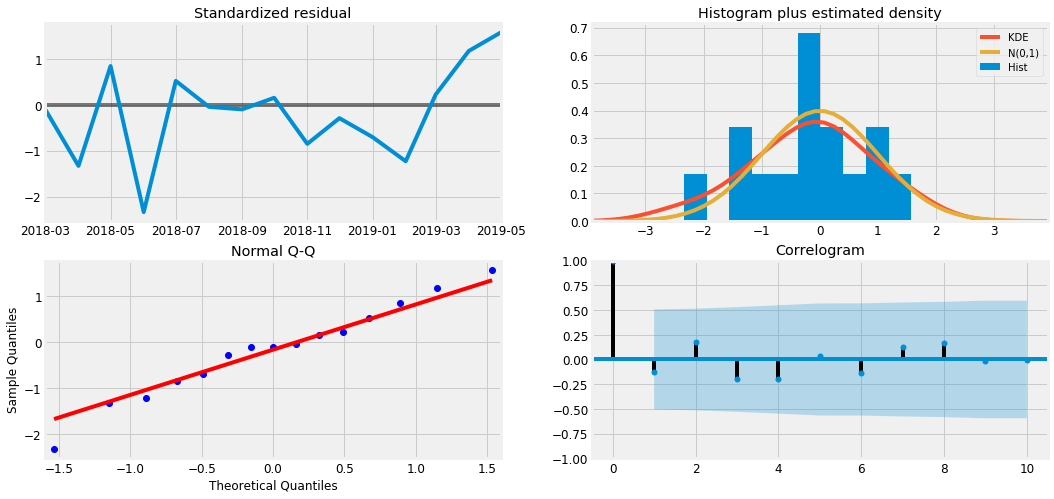

In [10]:
# Plitting model diagnostics to investigate unusual behavior.
# Residual is the difference between true and predicted value.

# Normal Quantile-Quantile is a way to visualize if the data were normally distributes. The closer to the line, the more normally distributed.
results.plot_diagnostics(figsize=(16, 8))
plt.show()

## Testing the model

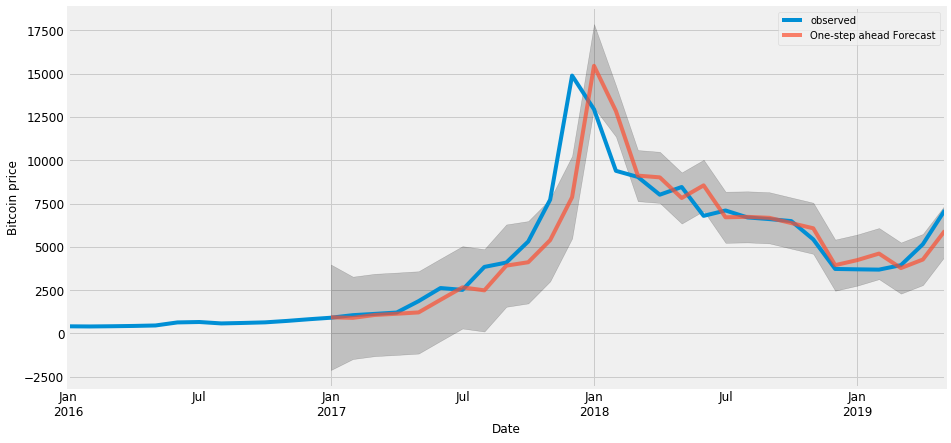

In [11]:
# Making a prediction from 1. Janurary 2017 to now, so we can compare the result with the actual observed graph.
pred = results.get_prediction(start=('2017-01-01'), dynamic=False)


# Plotting the observed graph and the 'one-step forecasting',
ax = month_hist.plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast', alpha=.7, figsize=(14, 7))

# Plotting the confidence interval on the forecast.
# This is the interval of the forecasts higest and lowest predicted price.
# The plotted line is the mean in the confidence interval.
pred_ci = pred.conf_int()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin price')
plt.legend()
plt.show()

In [12]:
# This is the confidence interval.
# It shows the difference between lower and upper values of predicted weighted price over time.
print(pred_ci)

            lower Weighted_Price  upper Weighted_Price
time                                                  
2017-01-01          -2112.227976           3976.868832
2017-02-01          -1479.220020           3277.043361
2017-03-01          -1311.018774           3442.725765
2017-04-01          -1240.797040           3512.945388
2017-05-01          -1162.927091           3590.815329
2017-06-01           -434.112181           4319.630239
2017-07-01            284.877195           5038.619615
2017-08-01            111.233029           4864.975450
2017-09-01           1539.425163           6293.167583
2017-10-01           1734.773106           6488.515526
2017-11-01           3010.743053           7764.485342
2017-12-01           5489.890983          10243.493515
2018-01-01          13045.639185          17867.509967
2018-02-01          11366.555520          14323.289446
2018-03-01           7639.108166          10590.114084
2018-04-01           7538.950043          10489.955961
2018-05-01

In [13]:
# Calculating the mean absolute error.
y_forecasted = pred.predicted_mean
y_truth = month_hist['2017-01-01':]

# Sklearn method takes the actual value and the predicted value as parameters.
# The mean absolute error is the mean difference between predicted and actual value
mae = mean_absolute_error(y_truth, y_forecasted)
print('Mean absolute error',mae)

Mean absolute error 982.5505965521312


## Future prediction

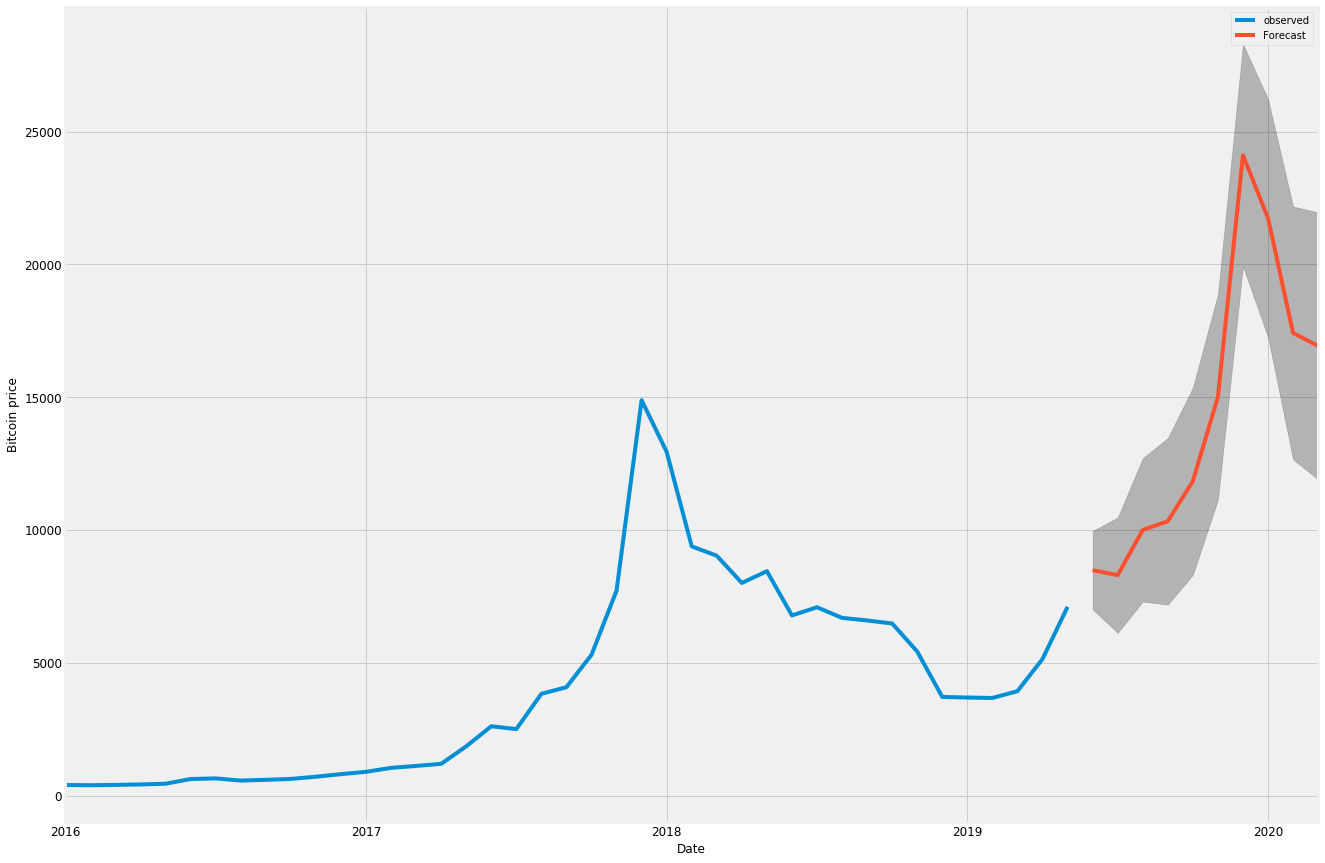

In [40]:
# We generate a forecast for the furture graph of Bitcoin.
# We call the method get_forecast which takes a parameter 'steps', as how many steps into the future do we want to forecast.
future_pred = results.get_forecast(steps=10)

# We plot the observed graph of Bitcoin prices.
ax = month_hist.plot(label='observed', figsize=(20, 15))
future_pred.predicted_mean.plot(ax=ax, label='Forecast')

# Plotting the confidence interval on the forecast.
# This is the interval of the forecasts higest and lowest predicted price.
# The plotted line is the mean in the confidence interval.
pred_ci = future_pred.conf_int()
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.25)

ax.set_xlabel('Date')
ax.set_ylabel('Bitcoin price')
plt.legend()
plt.show()

In [45]:
# Plotting the result in USD
future_pred.predicted_mean

2019-06-01     8495.990005
2019-07-01     8306.386064
2019-08-01    10008.633213
2019-09-01    10335.153855
2019-10-01    11841.104427
2019-11-01    15010.415678
2019-12-01    24106.638688
2020-01-01    21740.346861
2020-02-01    17419.479360
2020-03-01    16932.513517
Freq: MS, dtype: float64

## Conclusion
The model does seem to capture the trends and seasonality in the Bitcoin price. However, this also means that in the future it will predict the price to rise dramatically, like it did at some point in the training set.

---

# RNN LSTM Prediction
A **reccurent network** is networks with loops in them.
A loop allows information to be passed from on node in a network to another.
The image below illustrates a recurrent network. The loop to left is equal to the illustration of a loop on the right.
The network takes an input but also the output from the previous nodes as input to the current step.

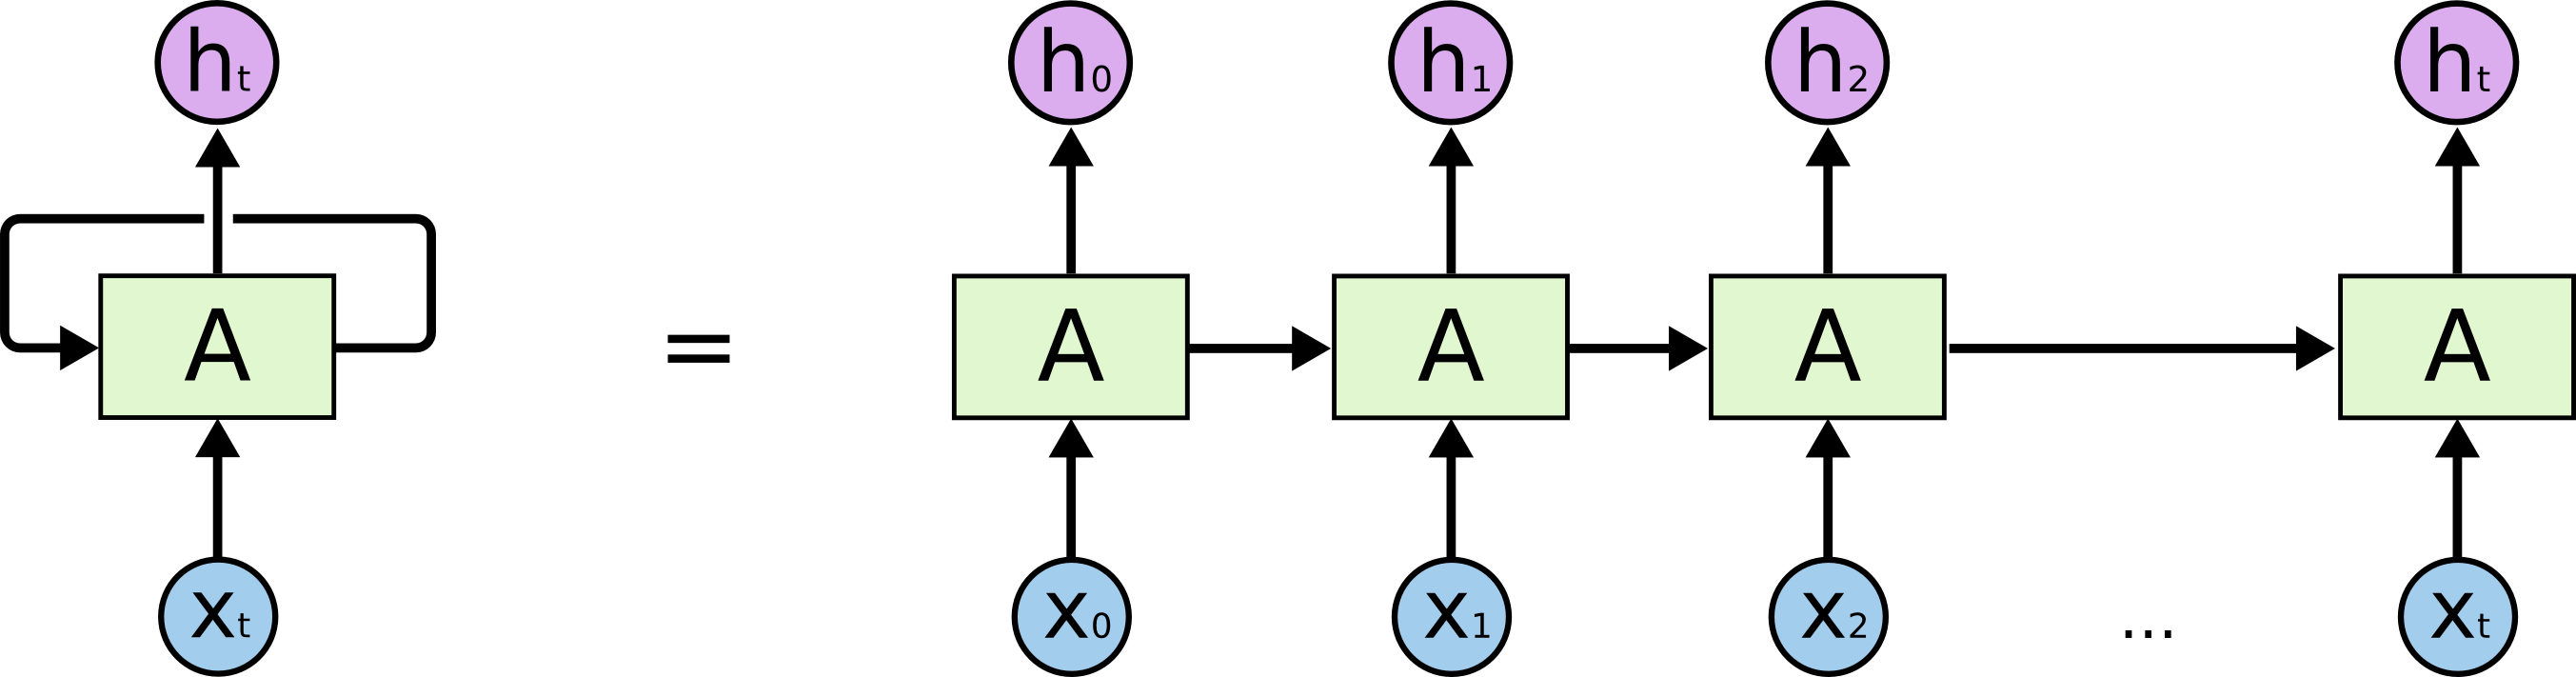


The idea behind the recurrent network is that it creates a kind of memory, which remembers all information about what has been calculated.

The **long-short term memory** comes into place as a hidden layer in the network. It's purpose is to enable RNN to remember inputs over a long period of time. The LSTM network has 3 gates. 
* Input gate, decides what is relevant to add from the current step.
* Forget gate, decides what is relevant to keep from prior steps and deletes information if it isn't important.
* Output gate, determines what the next hidden state should be.

With the above gates the model output the information to the next node & layer using Sigmoid and tanh layers.

In [15]:
# Reshaping numpy.ndarray from 1D array to 2D array
values = hist['Weighted_Price'].values.reshape(-1,1)
print(values[0])
# Converting the values to float.
values = values.astype('float32')
# Transform values to values between 0 and 1.
# This is the type of input LSTM takes.
scaler = MinMaxScaler(feature_range=(0, 1))
# Fit to data, then transform it.
scaled = scaler.fit_transform(values)

# Get the length of the new item scaled
print("Length of the new datframe : " + str(len(scaled)))

# Get the first 5 elements from the scaled dataframe
print(scaled[0:5,])

[1113.4375]
Length of the new datframe : 2001
[[0.05196624]
 [0.04434619]
 [0.03316076]
 [0.03275506]
 [0.03938658]]


In [16]:
# Divide scaled data into 80% train and 40% test with overlapping.
train_size = int(len(scaled) * 0.8)
print("Train Size : " + str(train_size))

test_size = int(len(scaled) * 0.6)
print("Test Size : " + str(len(scaled) - test_size))

train, test = scaled[:train_size,:], scaled[test_size:len(scaled),:]
print("Length of training data : " + str(len(train)))
print("Length of testing data : " + str(len(test)))

Train Size : 1600
Test Size : 801
Length of training data : 1600
Length of testing data : 801


In [17]:
# Function for creating dataset with look back (y refers to previous x)
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        # fx: 
        # 1st iteration - X:  [0.04680875] , Y:  0.051758032
        # 2nd iteration - X:  [0.05175803] , Y:  0.05387902
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [18]:
# Calling the create_dataset function with loop_back=1.
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(1599, 1)
(1599,)
(800, 1)
(800,)


In [19]:
# Transform from 2D array to 3D array
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

print(trainX.shape)
print(testX.shape)

(1599, 1, 1)
(800, 1, 1)


In [20]:
# Initialise the sequential model
model = Sequential()

# Add the LSTM hidden layer with 128 nodes
model.add(LSTM(128, input_shape=(trainX.shape[1], trainX.shape[2])))

# Adding a dropout layer of 0.2 to prevent overfitting.
model.add(Dropout(0.2))

# Add the output layer
model.add(Dense(1))

# Compile the model with Mean Absolute Error as the loss factor and ADAM as the optimiser
model.compile(loss='mae', optimizer='adam')

# Fit the model using the training and testing data
history = model.fit(trainX, trainY, epochs=300, batch_size=100, validation_data=(testX, testY), verbose=1, shuffle=False)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Train on 1599 samples, validate on 800 samples
Epoch 1/300
1599/1599 [==============================] - 1s 520us/step - loss: 0.0803 - val_loss: 0.2651
Epoch 2/300
1599/1599 [==============================] - 0s 42us/step - loss: 0.0783 - val_loss: 0.2557
Epoch 3/300
1599/1599 [==============================] - 0s 44us/step - loss: 0.0743 - val_loss: 0.2488
Epoch 4/300
1599/1599 [==============================] - 0s 44us/step - loss: 0.0696 - val_loss: 0.2330
Epoch 5/300
1599/1599 [==============================] - 0s 45us/step - loss: 0.0674 - val_loss: 0.2220
Epoch 6/300
1599/1599 [==============================] - 0s 40us/step - loss: 0.0636 - val_loss: 0.2098
Epoch 7/300
1599/1599 [==============================] - 0s 43us/step - loss: 0.0600 - val_lo

1599/1599 [==============================] - 0s 42us/step - loss: 0.0062 - val_loss: 0.0086
Epoch 147/300
1599/1599 [==============================] - 0s 45us/step - loss: 0.0054 - val_loss: 0.0089
Epoch 148/300
1599/1599 [==============================] - 0s 43us/step - loss: 0.0059 - val_loss: 0.0084
Epoch 149/300
1599/1599 [==============================] - 0s 42us/step - loss: 0.0051 - val_loss: 0.0084
Epoch 150/300
1599/1599 [==============================] - 0s 42us/step - loss: 0.0050 - val_loss: 0.0089
Epoch 151/300
1599/1599 [==============================] - 0s 43us/step - loss: 0.0056 - val_loss: 0.0086
Epoch 152/300
1599/1599 [==============================] - 0s 42us/step - loss: 0.0065 - val_loss: 0.0087
Epoch 153/300
1599/1599 [==============================] - 0s 42us/step - loss: 0.0066 - val_loss: 0.0094
Epoch 154/300
1599/1599 [==============================] - 0s 41us/step - loss: 0.0080 - val_loss: 0.0093
Epoch 155/300
1599/1599 [==============================] - 0

1599/1599 [==============================] - 0s 41us/step - loss: 0.0045 - val_loss: 0.0085


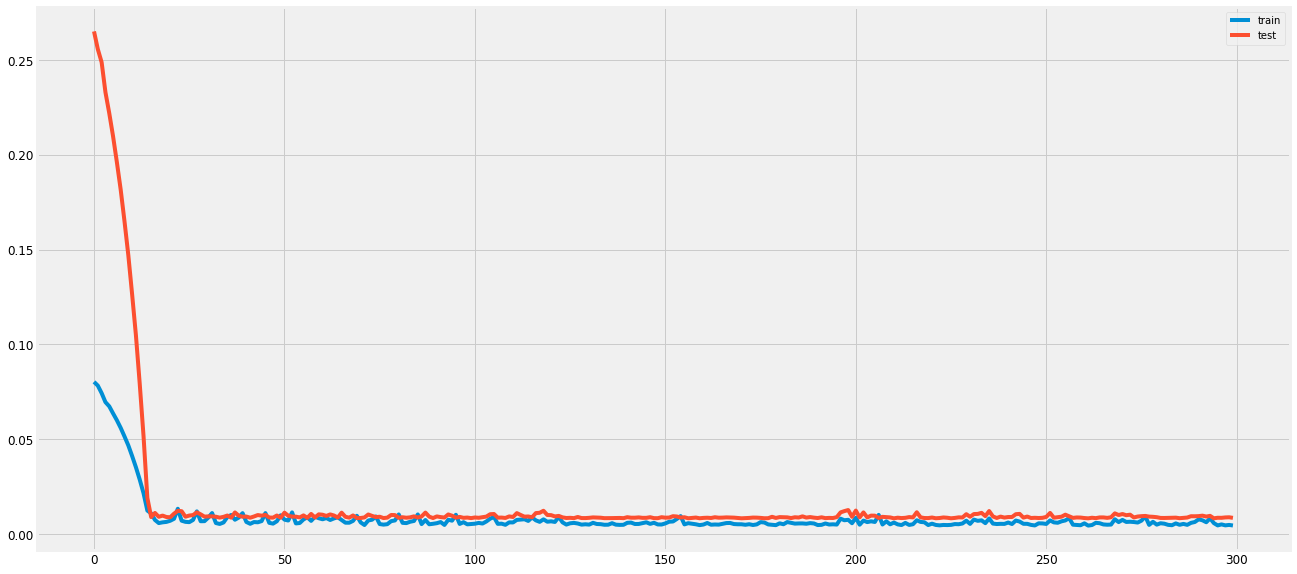

In [21]:
# Plotting the training loss vs the test validation loss.
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

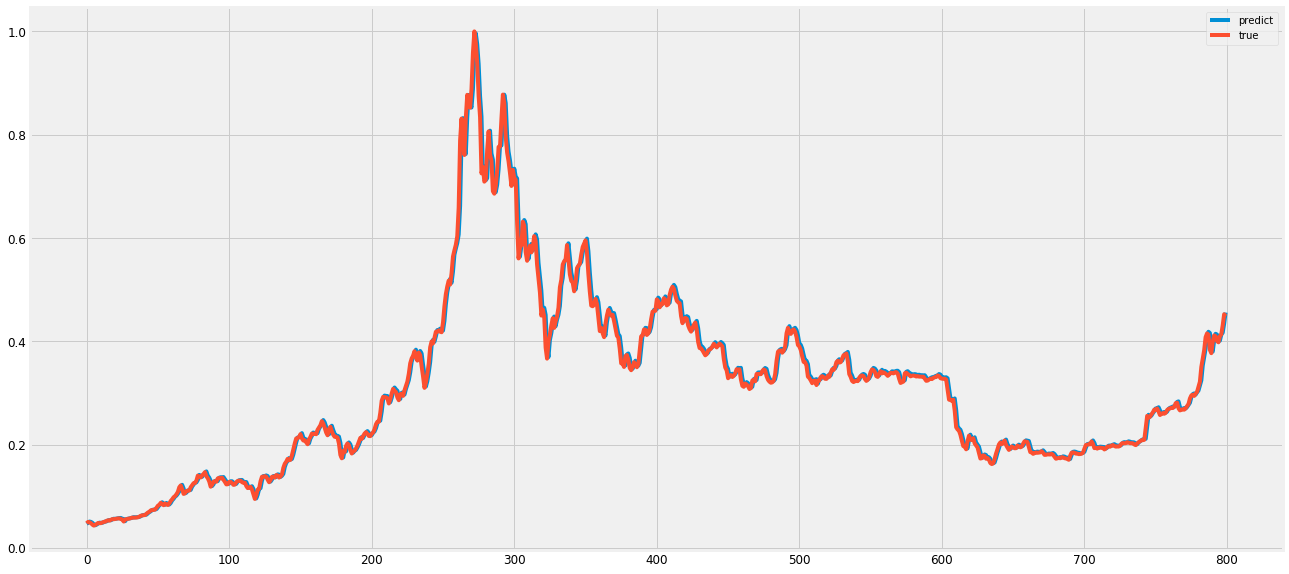

In [22]:
# We predict the values from testX.
yhat = model.predict(testX)

# Plotting the actual graph vs the predicted graph.
plt.plot(yhat, label='predict')
plt.plot(testY, label='true')
plt.legend()
plt.show()

In [23]:
# scaler = MinMaxScaler(feature_range=(0, 1)) as used before for fit_transform and MinMaxScaler
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

print(yhat_inverse.shape)
print(testY_inverse.shape)

print(yhat_inverse[0])
print(testY_inverse[0])

(800, 1)
(800, 1)
[1019.065]
[1033.165]


In [24]:
# Sklearn method takes the actual value and the predicted value as parameters.
# The mean absolute error is the mean difference between predicted and actual value
mae = mean_absolute_error(testY_inverse, yhat_inverse)
print('Mean absolute error',mae)

Mean absolute error 163.45726


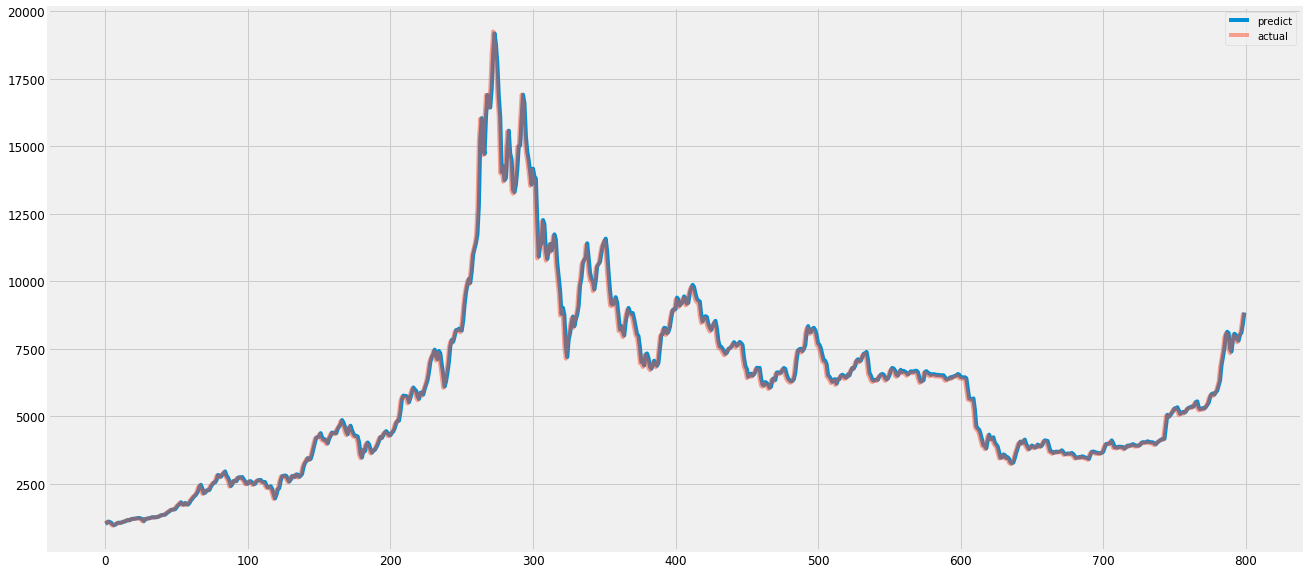

In [25]:
# Plotting prediction vs actual graph.
# This plotting shows the price.
plt.plot(yhat_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)
plt.legend()
plt.show()

In [33]:
# Creating a new variable containing the testX values.
# Just for good measure.
Xtest = testX

# Predicting the values from Xtest and appending the last preicted value
# to the set before predicting again
for i in range(30):
    future_preds = model.predict(Xtest) # Here yhat is the predicted value from the test set (y_pred)
    
    y = np.zeros((1,1,1))
    y[[0]] = future_preds[len(future_preds)-1][0]
    
    Xtest = np.append(Xtest, y, axis=0)

In [34]:
future_preds_inverse = scaler.inverse_transform(future_preds.reshape(-1, 1))

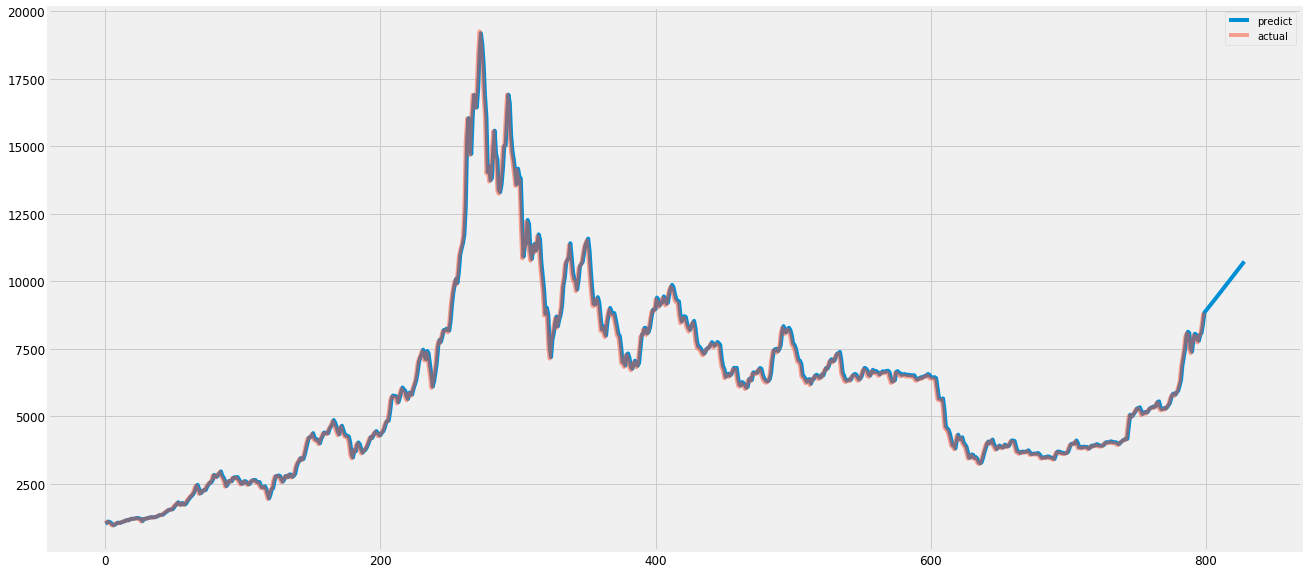

In [67]:
plt.plot(future_preds_inverse, label='predict')
plt.plot(testY_inverse, label='actual', alpha=0.5)

plt.legend()
plt.show()

# Refferences
* https://www.geeksforgeeks.org/introduction-to-recurrent-neural-network/ (28/05/2019)
* https://colah.github.io/posts/2015-08-Understanding-LSTMs/ (28/05/2019)
* https://towardsdatascience.com/recurrent-neural-networks-and-lstm-4b601dd822a5 (28/05/2019)

# Conclusion

By looking at the the plotted predictions compared to the actual values, and by looking at the mean absoluted error (MAE), it is very clear, that the best model on paper is our RNN LSTM model. The MAE of the SARIMA model is significantly higher than the one of the RNN LSTM model.However, the RNN LSTM model seems to have a random behaviour when predicting future values, which suggests the model is overfitted.

With this in mind we will save the SARIMA model for future predictions.

In [68]:
# Saving the model
future_pred.save('SARIMA_btc_pred.pkl')

In [ ]:
from sklearn.externals import joblib
from flask import Flask, request, jsonify, render_template
import pickle

# create an instance (our app)
app = Flask(__name__)

kmmodel = joblib.load('../Data/regressor.pkl')

@app.route('/', methods=['GET', 'POST'])
@app.route('/predicted-price')
def hello(name = None):
    return render_template('start.html', name=name)
# name is parameter in the template: {{name}}

@app.route('/predict')
def predict():
    return render_template('prediction.html')

@app.route('/predicted', methods=['GET', 'POST'])
def predicted():
    if request.method == 'POST':
        x1 = request.form['x1']
        x2 = request.form['x2']
        X = [[x1, x2]]
        predicted = kmmodel.predict(X)
          
        return render_template("predicted.html", content=X, prediction=predicted)
    
@app.route('/bye')
def bye():
    return render_template('bye.html')

if __name__ == '__main__':
    app.run(debug=True)